In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Principal Component Analysis

In [2]:
import numpy as np
from sklearn import preprocessing

def pca(data_array,principal_components,k):

    # calculate the covariance matrix
    covariance_matrix = np.cov(np.transpose(data_array))
    w, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvectors = np.real_if_close(eigenvectors, tol=1)

    # tranposes eigenvectors
    new_eigenvectors = preprocessing.normalize(np.transpose(eigenvectors))

    # gets each principal component
    for i in range(k):
        principal_components[i] = new_eigenvectors[i]

    # projected NBA team data onto these principal components
    projected_components = np.transpose(
        (data_array @ np.transpose(principal_components))
    )

    return np.transpose(projected_components)

# Cleaning Data

In [3]:
from api_helpers.team_stats_helpers import load_dataframe
import pandas as pd

nba_dataframe = load_dataframe(['FGM', 'FGA', 'FG_PCT', 'FG3A', 'FTM', 'OREB', 'DREB', 'REB', 'AST','PTS'])
nba_dataframe = nba_dataframe.drop(nba_dataframe[nba_dataframe["FGM"] == 0].index)
nba_dataframe.sort_values(by='YEAR')

nba_dataframe['YEAR'] = nba_dataframe['YEAR'].str.split('-').str[0]
nba_dataframe['YEAR'] = pd.to_numeric(nba_dataframe['YEAR'])
nba_dataframe.sort_values(by="YEAR",inplace=True)

nba_dataframe["NBA_FINALS_APPEARANCE"].fillna(0.0, inplace=True)
nba_dataframe["NBA_FINALS_APPEARANCE"].replace("FINALS APPEARANCE", 0, inplace=True)
nba_dataframe["NBA_FINALS_APPEARANCE"].replace("LEAGUE CHAMPION", 1, inplace=True)

nba_dataframe = nba_dataframe[nba_dataframe['YEAR'] >= 1996]
nba_dataframe = nba_dataframe.reset_index(drop=True)

nba_dataframe

/tmp/ipykernel_76547/2598323231.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nba_dataframe["NBA_FINALS_APPEARANCE"].fillna(0.0, inplace=True)
/tmp/ipykernel_76547/2598323231.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nba_dataframe["NBA_FINALS_APPEARANCE"].replace("LEAGUE CHAMPION",

,TEAM_ID,YEAR,NBA_FINALS_APPEARANCE,FGM,FGA,FG_PCT,FG3A,FTM,OREB,DREB,REB,AST,PTS
0,1610612738,1996,0.0,3066,6967,0.440,1331,1649,1095,2188,3283,1792,8248
1,1610612748,1996,0.0,2822,6235,0.453,1865,1454,957,2402,3359,1735,7776
2,1610612756,1996,0.0,3143,6705,0.469,1428,1618,916,2376,3292,2067,8431
3,1610612755,1996,0.0,3003,6850,0.438,1356,1776,1267,2355,3622,1695,8215
4,1610612745,1996,0.0,3037,6484,0.468,1839,1503,927,2565,3492,2013,8248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,1610612765,2023,0.0,3353,7236,0.463,2602,1398,861,2692,3553,2088,9010
828,1610612756,2023,0.0,3482,7063,0.493,2671,1548,831,2783,3614,2218,9532
829,1610612740,2023,0.0,3484,7165,0.486,2673,1445,852,2753,3605,2210,9436
830,1610612764,2023,0.0,3523,7493,0.470,2915,1266,755,2613,3368,2288,9327


# Use PCA to get Top-K Components

In [4]:
# use principal component analysis to find the top k eigenvectors
from tabulate import tabulate
import numpy as np

k = 2
columns_list = ['FGM', 'FGA', 'FG_PCT', 'FG3A', 'FTM', 'OREB', 'DREB', 'REB', 'AST','PTS','NBA_FINALS_APPEARANCE']

all_teams_array = np.array(nba_dataframe[columns_list])

championship_teams_index = nba_dataframe.index[nba_dataframe["NBA_FINALS_APPEARANCE"] == 1].to_list()

principal_components = [[0] * len(all_teams_array)] * k

top_k_components = pca(all_teams_array,principal_components,k)
print(len(top_k_components))

832


In [5]:
# select champion teams
print(len(top_k_components[0]))
champion_k_component_1 = [top_k_components[idx][0] for idx in championship_teams_index]
champion_k_component_2 = [top_k_components[idx][1] for idx in championship_teams_index]

2


# Scatter Plot of Primary Component vs Secondary Component

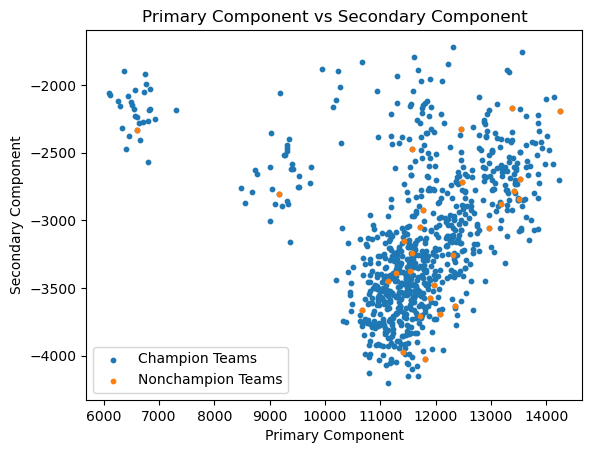

In [6]:
# plot data
from matplotlib import pyplot as plt

components = np.transpose(top_k_components)

plt.scatter(components[0],components[1],s=10)
plt.scatter(champion_k_component_1,champion_k_component_2,s=10)
plt.title("Primary Component vs Secondary Component")
plt.xlabel("Primary Component")
plt.ylabel("Secondary Component")
plt.legend(["Champion Teams", "Nonchampion Teams", "2023 Teams"])
plt.show()

# Create test/train split

In [7]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

selected_features = "PTS","FGM","FGA","FG_PCT","FG3M","FG3A","FG3_PCT","FTM","FTA","FT_PCT","OREB","DREB","REB","AST"

X_train, X_test, y_train, y_test = train_test_split(top_k_components,np.array(nba_dataframe["NBA_FINALS_APPEARANCE"]),test_size=0.25,random_state=10)

sm2 = SMOTE(random_state=10, sampling_strategy=0.8)
x_res, y_res = sm2.fit_resample(X_train, y_train)


In [8]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')

# Grid Search through SVM Model

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer, recall_score

param_grid = {
    'C': range(1,100,10),
    'gamma': (1,20,5),
    'kernel': ['linear', 'rbf']
}

# Create an SVM model
svm = SVC()

# Choose the scoring method
# For recall:
scorer = make_scorer(recall_score,pos_label=1.0)

# For F1 Score:
# scorer = make_scorer(f1_score)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring=recall_score,cv=2,verbose=2)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(


[CV] END .......................C=81, gamma=1, kernel=linear; total time=   0.2s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(
/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this trai

[CV] END .......................C=81, gamma=1, kernel=linear; total time=   0.3s
[CV] END ..........................C=81, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=81, gamma=1, kernel=rbf; total time=   0.0s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(


[CV] END ......................C=81, gamma=20, kernel=linear; total time=   0.2s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(
/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this trai

[CV] END ......................C=81, gamma=20, kernel=linear; total time=   0.3s
[CV] END .........................C=81, gamma=20, kernel=rbf; total time=   0.0s
[CV] END .........................C=81, gamma=20, kernel=rbf; total time=   0.0s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(


[CV] END .......................C=81, gamma=5, kernel=linear; total time=   0.2s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(
/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this trai

[CV] END .......................C=81, gamma=5, kernel=linear; total time=   0.3s
[CV] END ..........................C=81, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..........................C=81, gamma=5, kernel=rbf; total time=   0.0s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(


[CV] END .......................C=91, gamma=1, kernel=linear; total time=   0.5s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(
/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this trai

[CV] END .......................C=91, gamma=1, kernel=linear; total time=   0.6s
[CV] END ..........................C=91, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=91, gamma=1, kernel=rbf; total time=   0.0s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(


[CV] END ......................C=91, gamma=20, kernel=linear; total time=   0.4s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(
/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this trai

[CV] END ......................C=91, gamma=20, kernel=linear; total time=   0.6s
[CV] END .........................C=91, gamma=20, kernel=rbf; total time=   0.0s
[CV] END .........................C=91, gamma=20, kernel=rbf; total time=   0.0s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(


[CV] END .......................C=91, gamma=5, kernel=linear; total time=   0.5s


/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/usr/lib/python3.10/inspect.py", line 3112, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(
/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this trai

[CV] END .......................C=91, gamma=5, kernel=linear; total time=   0.6s
[CV] END ..........................C=91, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..........................C=91, gamma=5, kernel=rbf; total time=   0.0s
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best Score: nan


# Develop SVM Model

In [14]:
best_model.fit(x_res,y_res)
best_model.score(x_res, y_res)

0.5504162812210915

# Test Prediction against Test

In [15]:
import pandas as pd

# predict data and cross tab
y_pred = best_model.predict(X_test)
pd.crosstab(y_test, y_pred)

col_0,0.0
row_0,
0.0,203
1.0,5


# Print Metrics

In [16]:
import sklearn.metrics as metrics
print('accuracy is ' + str(metrics.accuracy_score(y_test, y_pred)))
print('mae is ' + str(metrics.mean_absolute_error(y_test, y_pred)))
print('recall is ' + str(metrics.recall_score(y_test, y_pred, average='weighted')))
print('precision is ' + str(metrics.precision_score(y_test, y_pred, average='weighted')))
print('r2 is ' + str(metrics.r2_score(y_test, y_pred)))


report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

accuracy is 0.9759615384615384
mae is 0.02403846153846154
recall is 0.9759615384615384
precision is 0.9525009245562129
r2 is -0.024630541871921263
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       203
         1.0       1.00      0.00      0.00         5

    accuracy                           0.98       208
   macro avg       0.99      0.50      0.49       208
weighted avg       0.98      0.98      0.96       208



/home/rohanbendapudi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Confusion Matrix

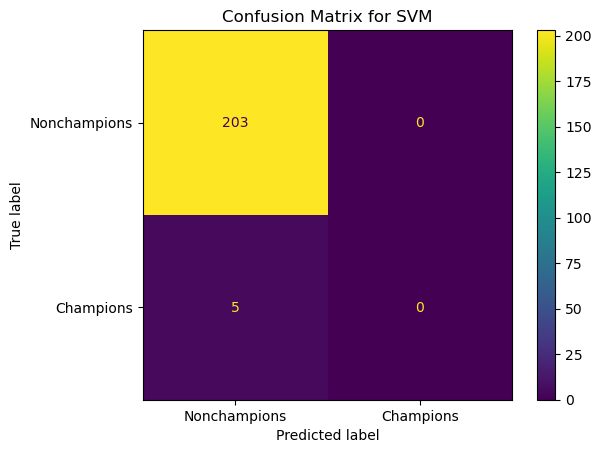

In [17]:
# show a confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=["Nonchampions", "Champions"]
)
cm_display.plot()
plt.title("Confusion Matrix for SVM")
plt.show()